<a href="https://colab.research.google.com/github/i-ganza007/Call_of_the_wild/blob/main/Summative_Intro_to_ml_%5BIan_Ganza%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [1]:
import librosa
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import pandas as pd
import os
import numpy as np
import random
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from PIL import Image

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [ ]:
"""
The aim of this project is to build a model that is able to classify birds by it's sounds
We will be using the Wester Mediterranean Wetland Birds Dataset (https://zenodo.org/record/7505820#.Y-zEQXbMJD9)
that has been manually labeled with species of the Aiguamolls del Empordà natural park in Girona, Spain.
The dataset contains 20 classes of different species represented in 5,795  audio files
"""

In [2]:
# Getting data
!wget -O spectograms.zip "https://zenodo.org/records/7505820/files/spectrograms.zip?download=1"
!wget -O audio.zip 'https://zenodo.org/records/7505820/files/audio_files.zip?download=1'
!unzip -q spectograms.zip -d spectrograms
!unzip -q audio.zip -d audio


--2025-06-18 09:51:52--  https://zenodo.org/records/7505820/files/spectrograms.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2981250025 (2.8G) [application/octet-stream]
Saving to: ‘spectograms.zip’

spectograms.zip     100%[===================>]   2.78G  1.94MB/s    in 23m 48s 

2025-06-18 10:15:41 (1.99 MB/s) - ‘spectograms.zip’ saved [2981250025/2981250025]

--2025-06-18 10:15:42--  https://zenodo.org/records/7505820/files/audio_files.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1041126810 (993M) [application/octet-stream]
Saving to: ‘audio.zip’

audio.zip           100%[===================>] 992.90M  1.92MB/s    in 19m 38s

<img src='/content/Untitled-2025-02-22-2205(3).png'/>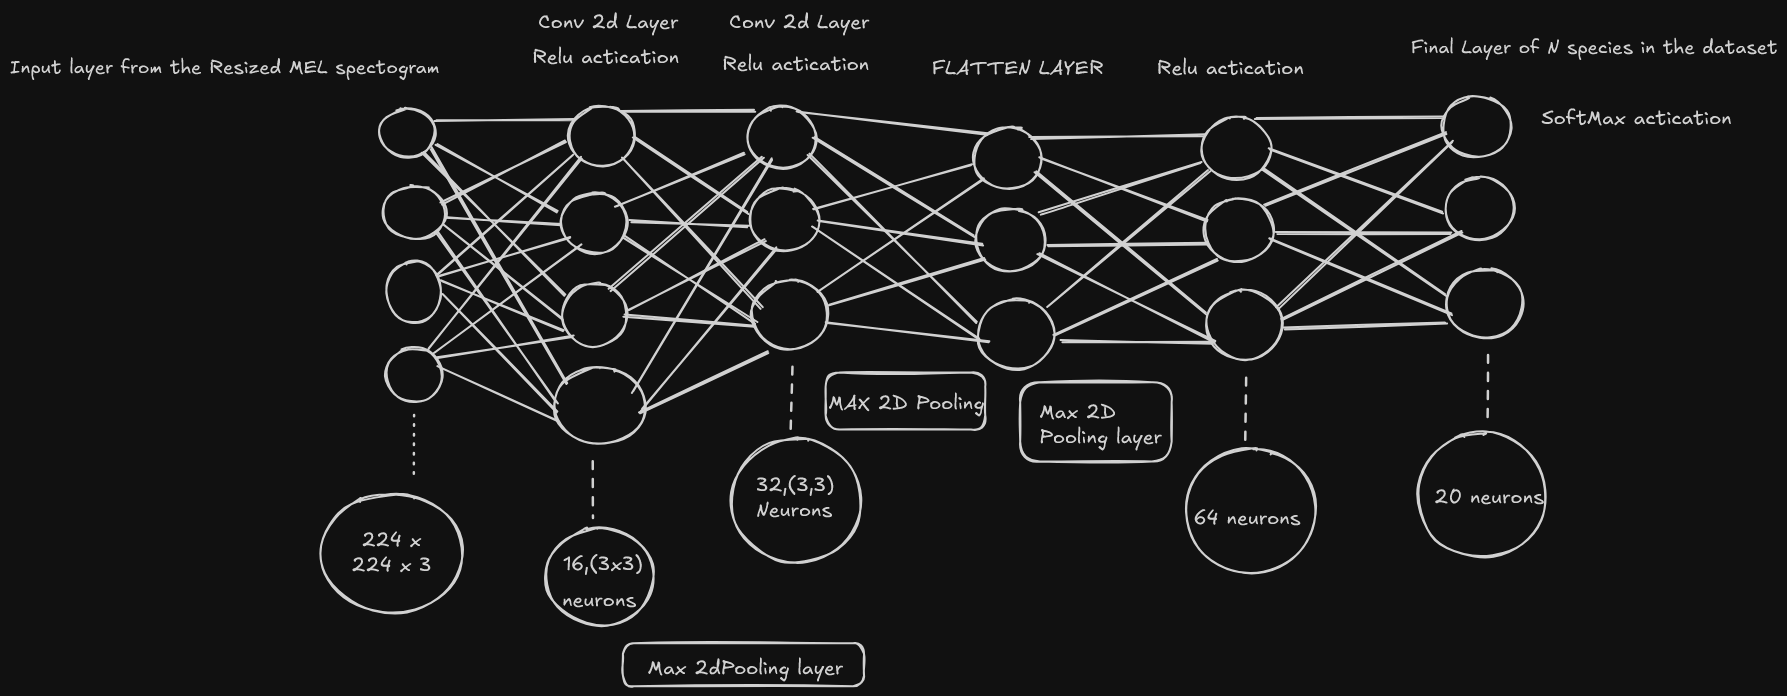

In [3]:
SPECTOGRAMS_PATH = "/content/spectrograms"
AUDIO_PATH = "/content/audio"
METADATA_PATH = "/content/metadata.csv"
metadata_df = pd.read_csv(METADATA_PATH,sep=";")
metadata_df.head()

,species,audio_name,spectrogram_name,sec_i,sec_f
0,Acrocephalus arundinaceus,XC417157.mp3,XC417157_0.npy,2.168,3.168
1,Acrocephalus arundinaceus,XC417157.mp3,XC417157_1.npy,2.968,3.968
2,Acrocephalus arundinaceus,XC417157.mp3,XC417157_2.npy,3.768,4.768
3,Acrocephalus arundinaceus,XC417157.mp3,XC417157_3.npy,4.568,5.108
4,Acrocephalus arundinaceus,XC417157.mp3,XC417157_4.npy,19.289,20.289


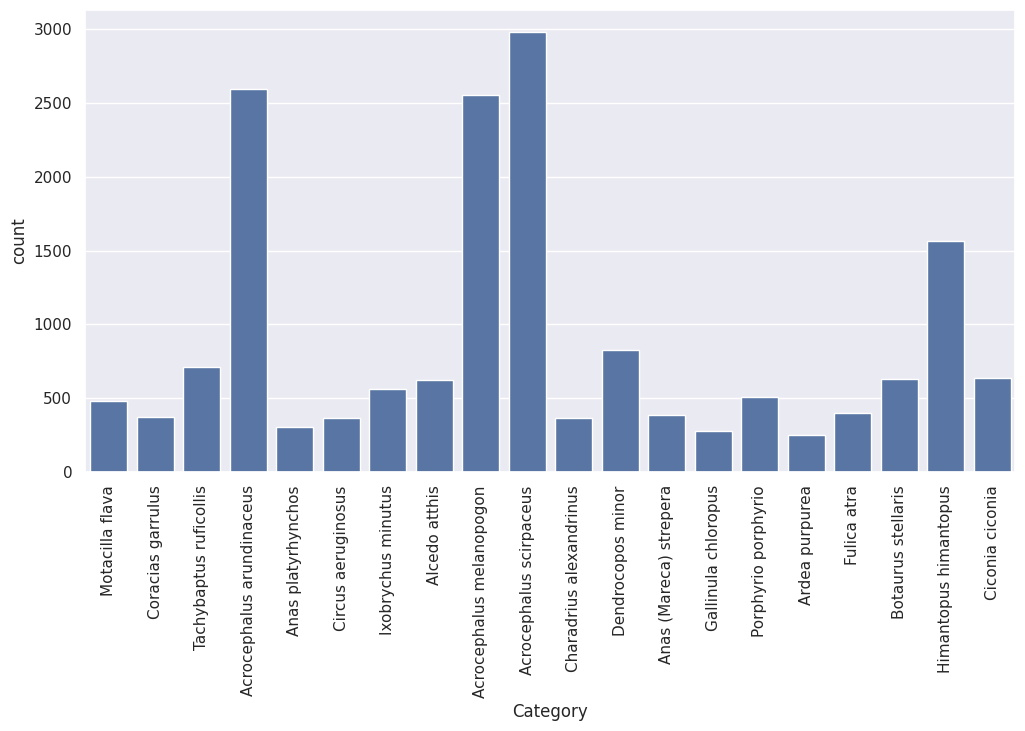

In [4]:
sns.set(rc={'figure.figsize':(12,6)})
data = []
for root, dirs, files in os.walk('spectrograms'):
    for file in files:
        category = os.path.basename(root)
        data.append({'filename': os.path.join(root, file), 'Category': category})

spectograms_df = pd.DataFrame(data)
sns.countplot(data=spectograms_df, x="Category")
plt.xticks(rotation=90)
plt.show()


In [5]:
spectograms_df['Category'].value_counts()

,count
Category,
Acrocephalus scirpaceus,2983
Acrocephalus arundinaceus,2599
Acrocephalus melanopogon,2555
Himantopus himantopus,1566
Dendrocopos minor,826
Tachybaptus ruficollis,710
Ciconia ciconia,636
Botaurus stellaris,629
Alcedo atthis,624


In [6]:
# Mapping the data to npy files from specto
def load_metadata_folders(PATH):

    df = []
    categories = os.listdir(PATH)
    for category in categories:
        for entry in os.listdir(PATH + '/' + category):
            df.append([entry,category])
    return df

spectograms_df = pd.DataFrame(load_metadata_folders(SPECTOGRAMS_PATH),columns=["File","Category"])
audio_df = pd.DataFrame(load_metadata_folders(AUDIO_PATH),columns=["File","Category"])
spectograms_df.head()

,File,Category
0,XC422437_7.npy,Motacilla flava
1,XC379953_7.npy,Motacilla flava
2,XC422437_41.npy,Motacilla flava
3,XC270056_29.npy,Motacilla flava
4,XC422437_8.npy,Motacilla flava


In [7]:
# Training Test Split Starting
# Split functions with labels
def train_val_test_split(df, categories, split_names, split_ratios):

    df['Split'] = None

    for category in categories:
        category_df = df[df['Category'] == category]
        total_count = len(category_df)
        current_index = 0
        for name, ratio in zip(split_names, split_ratios):
            split_count = int(total_count * (ratio / 100))
            df.loc[category_df.index[current_index:current_index + split_count], 'Split'] = name
            current_index += split_count

        if current_index < total_count:
            df.loc[category_df.index[current_index:total_count], 'Split'] = split_names[-1]

train_val_test_split(spectograms_df, spectograms_df['Category'].unique(), ['TRAIN', 'VAL', 'TEST'], [70, 20, 10])
spectograms_df.head()

,File,Category,Split
0,XC422437_7.npy,Motacilla flava,TRAIN
1,XC379953_7.npy,Motacilla flava,TRAIN
2,XC422437_41.npy,Motacilla flava,TRAIN
3,XC270056_29.npy,Motacilla flava,TRAIN
4,XC422437_8.npy,Motacilla flava,TRAIN


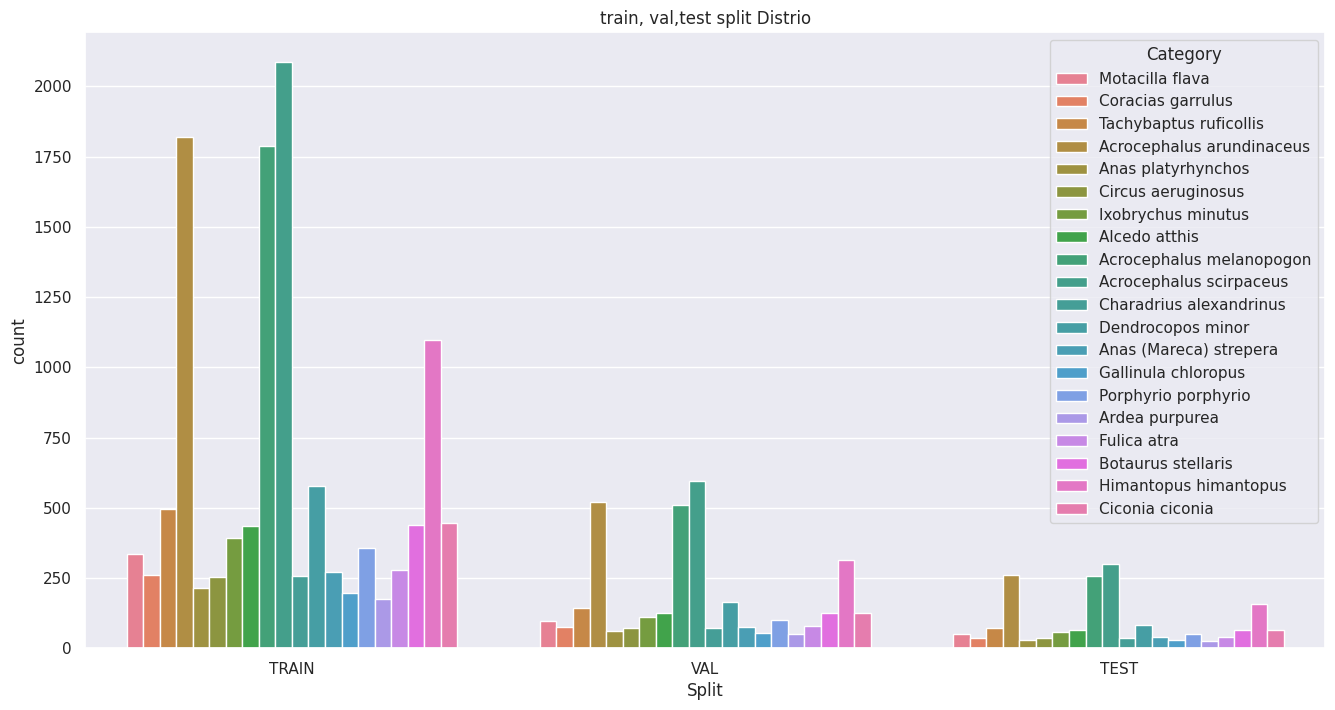

In [8]:
# Visualisation of the splits
plt.figure(figsize=(16,8))
sns.countplot(data=spectograms_df,x="Split",hue="Category").set(title="train, val,test split Distrio");

In [9]:


# Further spectogram labelling with audio extraction
def get_split_labels(n,labels,cuts):

    cuts = np.array(cuts)/100
    assigned_labels=[]
    for i in range(n):
        randint = np.random.rand()
        if (randint <= cuts[0]):
            assigned_labels.append(labels[0])
        if ((randint > cuts[0]) & (randint <= (cuts[0] + cuts[1]))):
            assigned_labels.append(labels[1])
        if ((randint > cuts[0] + cuts[1]) & (randint <= (cuts[0] + cuts[1] + cuts[2]))):
            assigned_labels.append(labels[2])
    return assigned_labels


def train_val_test_split(df,categories,labels,cuts):

    for category in categories:
        df.loc[df['Category'] == category,'Set'] = get_split_labels(df[df['Category'] == category].shape[0],labels,cuts)

def load_metadata_filtered(PATH, file_extension):

    df = []
    categories = os.listdir(PATH)
    for category in categories:
        category_path = os.path.join(PATH, category)
        if os.path.isdir(category_path):
            for entry in os.listdir(category_path):
                if entry.endswith(file_extension):
                    df.append([entry, category])
    return pd.DataFrame(df, columns=["File", "Category"])

audio_txt_df = load_metadata_filtered(AUDIO_PATH, '.txt')



In [10]:
# Audio mapping and normalization with feature extraction
def extract_audio_features(txt_paths,labels,categories,ids, window_size):
    audio_features_list = []

    for i,txt_path in enumerate(txt_paths):
        if(i % 50 == 0):
            print(f'Processing {i+1}/{len(txt_paths)}...')
        audio_path = txt_path.replace('.txt', '.mp3')

        set_label = labels[i]
        category = categories[i]
        bird_id = ids[i]
        if not (os.path.isfile(txt_path) and os.path.isfile(audio_path)):
            print(f'File(s) not found: {txt_path} and/or {audio_path}, ignoring...')
            continue
        try:
            y, sr = librosa.load(audio_path)
        except Exception as e:
            print(f"Error loading audio file {audio_path}: {e}, ignoring...")
            continue


        df = pd.read_csv(txt_path, delimiter='\t')

        for index, row in df.iterrows():
            start_time = row[0]
            end_time = row[1]

            if len(row) > 2:
                segment_label = row[2]
            else:
                segment_label = None

            windows_count = int((end_time - start_time) / window_size)
            if (windows_count == 0):
                windows_count = 1
            for j in range(windows_count):
                window_start_time = start_time + j * window_size
                window_end_time = window_start_time + window_size

                window_end_time = min(window_end_time, librosa.get_duration(y=y, sr=sr))

                y_segment = y[int(window_start_time*sr):int(window_end_time*sr)]

                if len(y_segment) == 0:
                    print(f"Skipping empty audio segment at {audio_path} from {window_start_time} to {window_end_time}")
                    continue

                try:
                    chroma_stft =librosa.feature.chroma_stft(y=y_segment, sr=sr)[0]
                    rmse = librosa.feature.rms(y=y_segment)[0]
                    spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
                    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)[0]
                    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
                    zcr = librosa.feature.zero_crossing_rate(y_segment)[0]
                    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr)[0]

                    audio_features = {
                        'id' : bird_id,
                        'start_time': window_start_time,
                        'end_time': window_end_time,
                        'chroma_stft': chroma_stft,
                        'rmse': rmse,
                        'spectral_centroid': spectral_centroid,
                        'spectral_bandwidth': spectral_bandwidth,
                        'rolloff': rolloff,
                        'zcr': zcr,
                        'mfcc': mfcc,
                        'label': set_label,
                        'category':category,
                        'segment_label': segment_label
                        }

                    audio_features_list.append(audio_features)
                except Exception as e:
                    print(f"Error extracting features for segment at {audio_path} from {window_start_time} to {window_end_time}: {e}, ignoring...")
                    continue


    df = pd.DataFrame(audio_features_list)

    return df

In [11]:
warnings.filterwarnings("ignore")
labels = get_split_labels(len(audio_txt_df),['TRAIN','VAL','TEST'],[70,20,10])
audio_txt_df['PATH'] = AUDIO_PATH + '/' + audio_txt_df['Category'] + '/' + audio_txt_df['File']
ids = list(audio_txt_df['File'].str.replace(".txt",""))
audio_features_df = extract_audio_features(audio_txt_df['PATH'],labels,audio_txt_df['Category'].to_list(),ids,window_size=1)

Processing 1/879...
Processing 51/879...
Processing 101/879...
File(s) not found: /content/audio/Acrocephalus arundinaceus/XC488301.txt and/or /content/audio/Acrocephalus arundinaceus/XC488301.mp3, ignoring...
File(s) not found: /content/audio/Acrocephalus arundinaceus/XC488300.txt and/or /content/audio/Acrocephalus arundinaceus/XC488300.mp3, ignoring...
Processing 151/879...
Processing 201/879...
Skipping empty audio segment at /content/audio/Ixobrychus minutus/XC180605.mp3 from 103.64 to 101.11609977324262
Skipping empty audio segment at /content/audio/Ixobrychus minutus/XC180605.mp3 from 106.67 to 101.11609977324262
Processing 251/879...
Processing 301/879...
Processing 351/879...
Processing 401/879...
Processing 451/879...
Processing 501/879...
Processing 551/879...
Processing 601/879...
Processing 651/879...
Processing 701/879...
Processing 751/879...
Processing 801/879...
Processing 851/879...


In [12]:
exploded_audios_df = audio_features_df.explode(['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zcr','mfcc'])
exploded_audios_df.head()

,id,start_time,end_time,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zcr,mfcc,label,category,segment_label
0,XC428706,6.625029,7.625029,0.048669,0.031459,5229.335988,1363.072338,5813.964844,0.224121,-316.185883,TRAIN,Motacilla flava,song
0,XC428706,6.625029,7.625029,0.069018,0.033762,5300.964064,1458.4381,5857.03125,0.348145,-330.339996,TRAIN,Motacilla flava,song
0,XC428706,6.625029,7.625029,0.038148,0.048986,5345.252193,1865.613998,6384.594727,0.477051,-366.79126,TRAIN,Motacilla flava,song
0,XC428706,6.625029,7.625029,0.000636,0.042839,5564.579441,1507.47179,5781.665039,0.495605,-393.153381,TRAIN,Motacilla flava,song
0,XC428706,6.625029,7.625029,0.000177,0.044152,5642.340654,1318.988686,5770.898438,0.504395,-418.303986,TRAIN,Motacilla flava,song


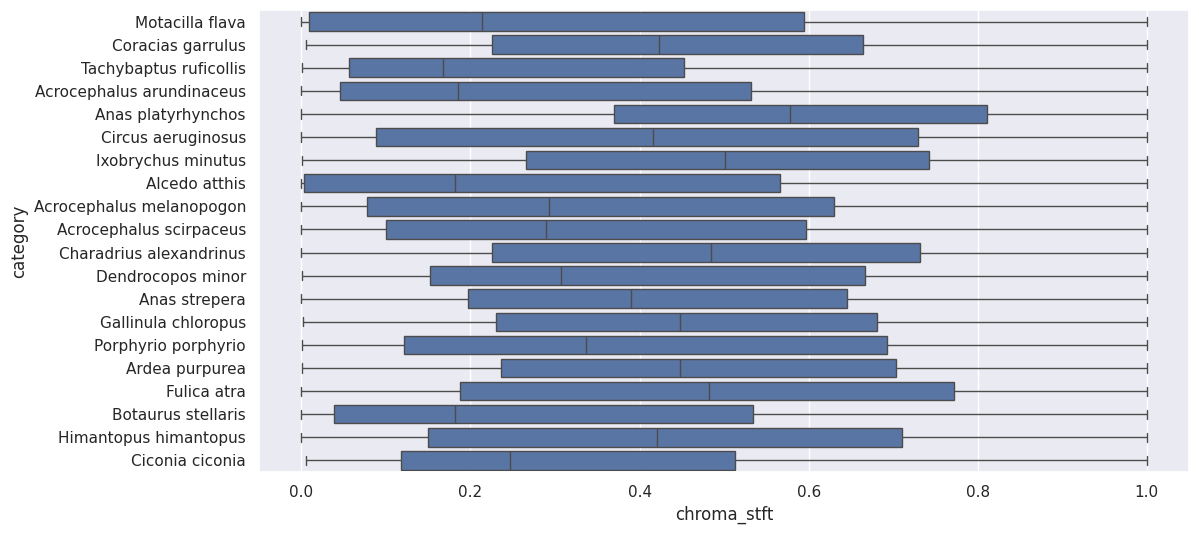

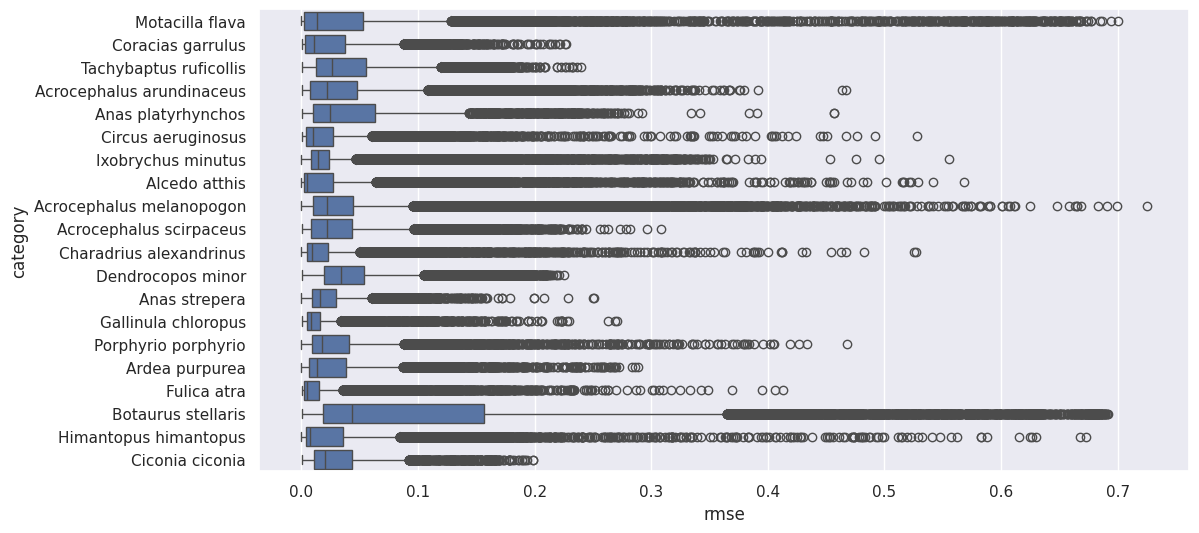

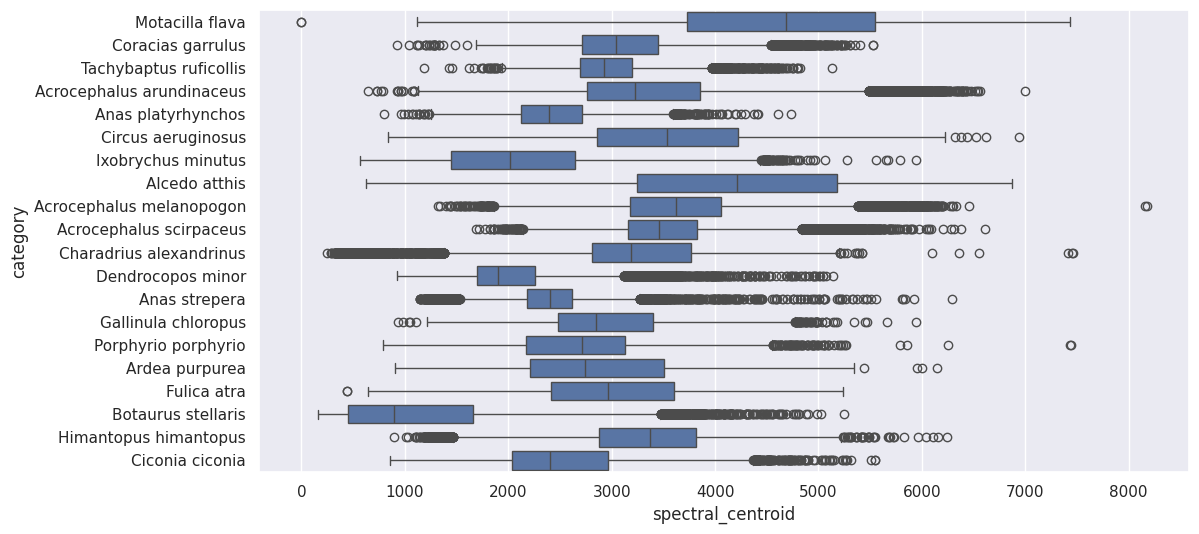

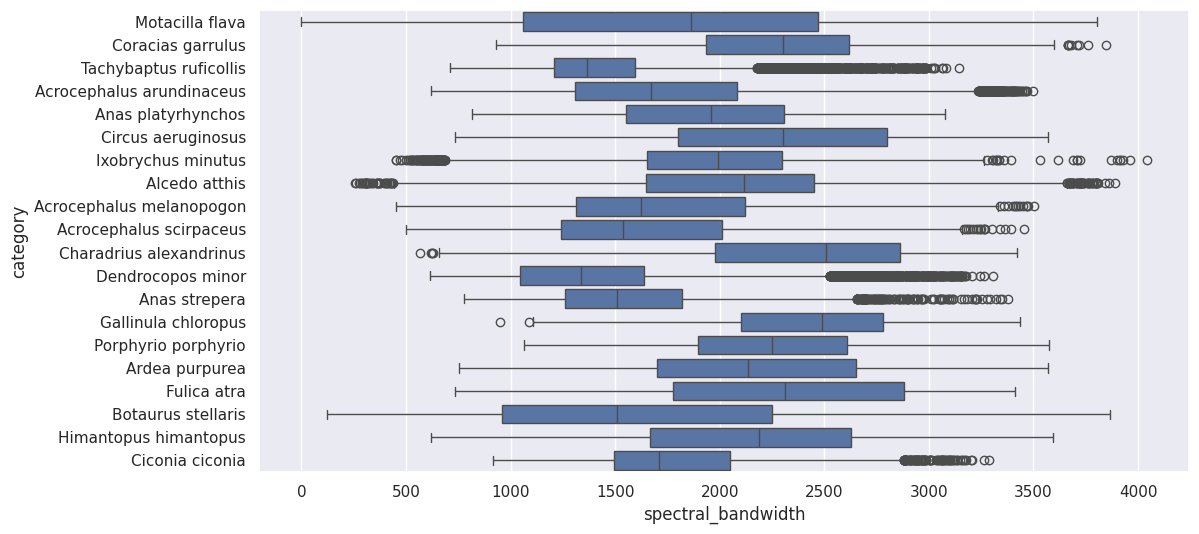

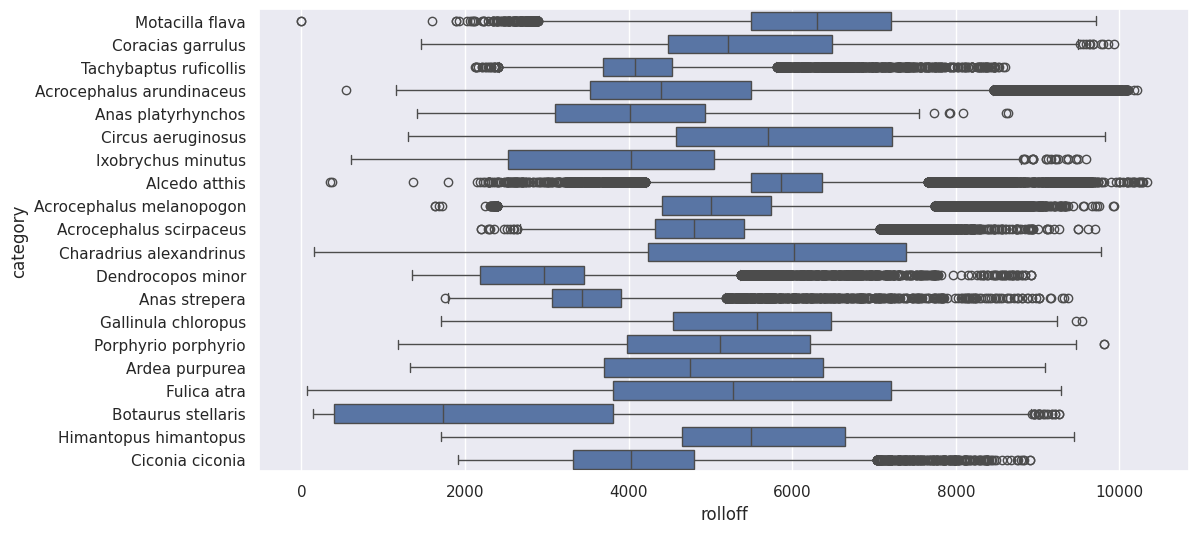

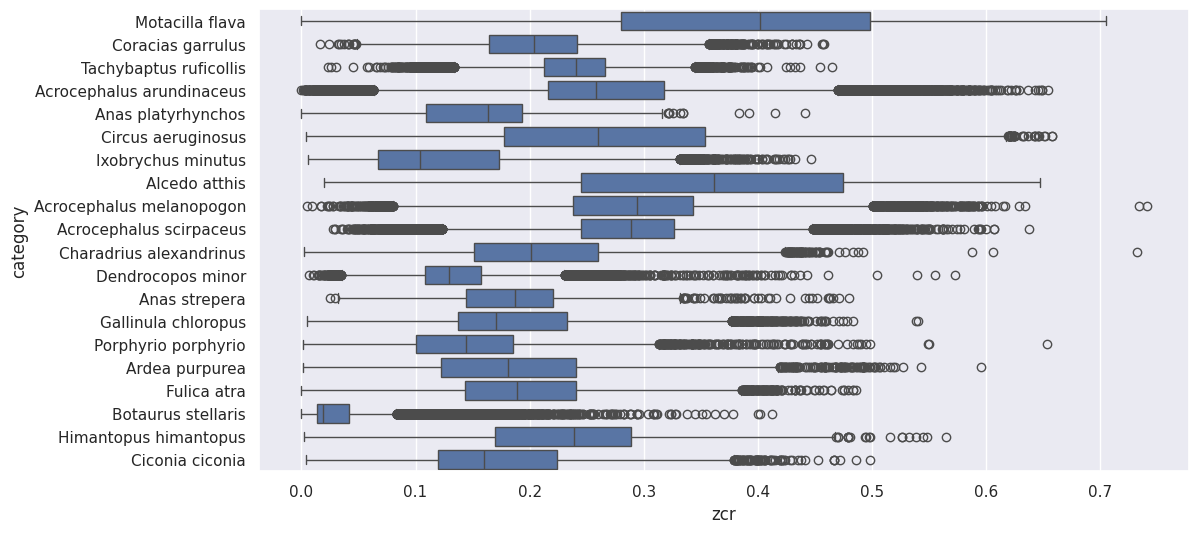

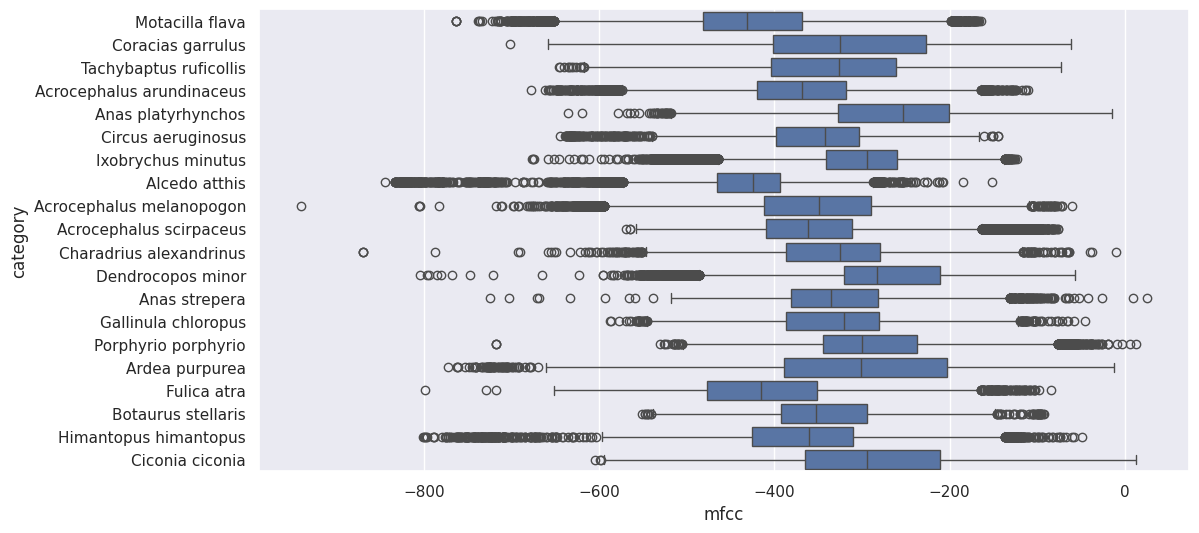

In [13]:
predictors = [ 'chroma_stft', 'rmse','spectral_centroid',
              'spectral_bandwidth','rolloff', 'zcr', 'mfcc']
for predictor in predictors:
    sns.boxplot(data=exploded_audios_df,x=predictor, y="category")
    plt.show()

In [14]:
def remove_outliers(df, columns, n_std):

    for col in columns:
        print('Dropping outliers on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean + (n_std * sd))]

    return df
def group_df_by_index(df):
    grouped = df.groupby(df.index)
    result = grouped.agg(lambda x: x.value_counts().index[0])
    return result

In [15]:
TRAIN = exploded_audios_df[exploded_audios_df['label'] == 'TRAIN']
TEST = exploded_audios_df[(exploded_audios_df['label'] == 'TEST') | (exploded_audios_df['label'] == 'VAL')]

In [16]:
X = TRAIN[predictors]
y = TRAIN['category']

sampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = sampler.fit_resample(X, y)

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-1))
clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(tol=0.1))])

In [17]:
test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
test_preds.head(5)


,0
32,Acrocephalus melanopogon
32,Motacilla flava
32,Motacilla flava
32,Motacilla flava
32,Himantopus himantopus


In [18]:
grouped_test_preds = group_df_by_index(test_preds)
grouped_test_preds.columns = ['category']
GT_grouped_test = group_df_by_index(TEST)
grouped_test_preds.head(5)

,category
32,Motacilla flava
33,Motacilla flava
34,Motacilla flava
35,Ciconia ciconia
36,Motacilla flava


In [19]:
TRAIN_NO_OUTLIERS = remove_outliers(TRAIN,predictors,2.5)

Dropping outliers on column: chroma_stft
Dropping outliers on column: rmse
Dropping outliers on column: spectral_centroid
Dropping outliers on column: spectral_bandwidth
Dropping outliers on column: rolloff
Dropping outliers on column: zcr
Dropping outliers on column: mfcc


In [21]:
X = TRAIN_NO_OUTLIERS[predictors]
y = TRAIN_NO_OUTLIERS['category']

GT_grouped_test = group_df_by_index(TEST)

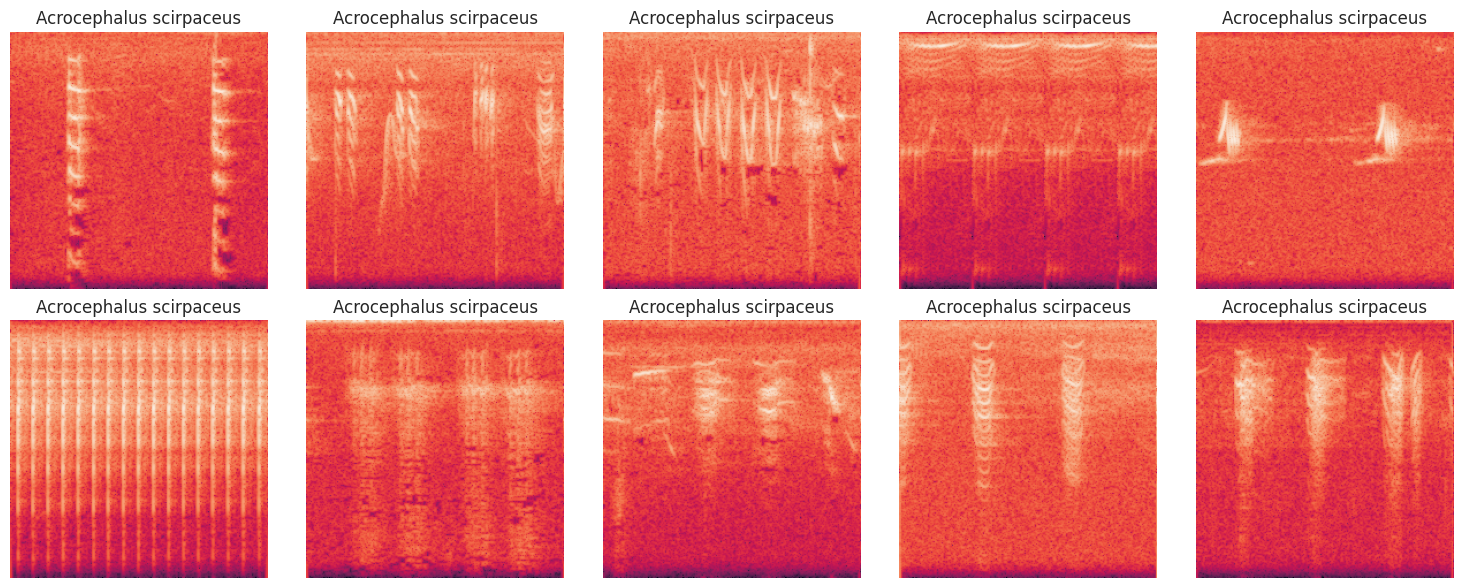

In [22]:
train_val_test_split(spectograms_df, spectograms_df['Category'].unique(), ['TRAIN', 'VAL', 'TEST'], [70, 20, 10])

spectograms_df_tmp = spectograms_df.copy()
spectograms_df_tmp['File'] =  spectograms_df['Category'] + '/' + spectograms_df['File']
df_train = spectograms_df_tmp[spectograms_df_tmp['Set'] == 'TRAIN']
df_val = spectograms_df_tmp[spectograms_df_tmp['Set'] == 'VAL']

random_indices = random.sample(range(spectograms_df_tmp.shape[0]), 10)

images = []
for index in random_indices:
    file = spectograms_df_tmp.iloc[index]['File']
    label = spectograms_df_tmp.iloc[index]['Category']
    image = np.load(SPECTOGRAMS_PATH + '/'+ file)
    images.append(image)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"{label}")
plt.tight_layout()
plt.show()

#Task: Define a function that creates models without and With specified Optimization techniques


In [36]:

from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score,
    recall_score, accuracy_score
)
import joblib


def sgd_class():
    X = TRAIN_NO_OUTLIERS[predictors]
    y = TRAIN_NO_OUTLIERS['category']

    kf = KFold(n_splits=5, shuffle=True)
    accuracies = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    best_f1 = -1
    best_model = None
    last_cf_mat = None

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=2000, tol=1e-1))
        clf.fit(X_resampled, y_resampled)

        test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
        grouped_test_preds = group_df_by_index(test_preds)
        grouped_test_preds.columns = ['category']

        GT_grouped_test = group_df_by_index(TEST)
        GT_grouped_test = GT_grouped_test.reindex(grouped_test_preds.index)

        y_true = GT_grouped_test['category']
        y_pred = grouped_test_preds['category']

        cf_mat = confusion_matrix(y_true, y_pred)
        last_cf_mat = cf_mat

        f1 = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

        accuracies.append(acc)
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

        if f1 > best_f1:
            best_f1 = f1
            best_model = clf

    print(f"Average Accuracy     : {np.mean(accuracies) * 100:.2f}%")
    print(f"Average F1-score     : {np.mean(f1_scores) * 100:.2f}%")
    print(f"Average Precision    : {np.mean(precision_scores) * 100:.2f}%")
    print(f"Average Recall       : {np.mean(recall_scores) * 100:.2f}%")

    sns.heatmap(last_cf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Last Fold)")
    plt.show()

    joblib.dump(best_model, 'best_sgd_model.pkl')


In [46]:
from tensorflow.keras import regularizers

def simple_cnn():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        return img, label

    BATCH_SIZE = 128

    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))
    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(train_dataset, epochs=7, validation_data=val_dataset)

    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
        plt.legend(['train', 'val'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()

    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
        plt.legend(['train', 'val'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.show()

    model.save("saved_simple_cnn_model.keras")


In [39]:
import joblib

def random_for_class():
    def classif_model_kfold(X, y, predictors, TEST, group_df_by_index, n_splits=5):
        models = [RandomForestClassifier()]
        results = []

        sampler = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = sampler.fit_resample(X, y)

        kf = KFold(n_splits=n_splits)

        for (i, model) in enumerate(models):
            print("[PROGRESS] Fitting model {} of {}".format(i + 1, len(models)))
            accuracies, f1_scores, precision_scores, recall_scores, cf_mats = [], [], [], [], []

            best_f1 = -1
            best_model = None

            for train_index, val_index in kf.split(X_resampled):
                X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
                y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

                clf = make_pipeline(StandardScaler(), model)
                clf.fit(X_train, y_train)

                test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
                grouped_test_preds = group_df_by_index(test_preds)
                grouped_test_preds.columns = ['category']
                GT_grouped_test = group_df_by_index(TEST)

                y_true = GT_grouped_test['category']
                y_pred = grouped_test_preds['category']

                cf_mat = confusion_matrix(y_true, y_pred)
                accuracy = np.trace(cf_mat) / np.sum(cf_mat)
                f1_sc = f1_score(y_true, y_pred, average='macro')
                precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

                accuracies.append(accuracy)
                f1_scores.append(f1_sc)
                precision_scores.append(precision)
                recall_scores.append(recall)
                cf_mats.append(cf_mat)

                if f1_sc > best_f1:
                    best_f1 = f1_sc
                    best_model = clf

            results.append({
                'model': model.__class__.__name__,
                'accuracy': np.mean(accuracies),
                'f1_score': np.mean(f1_scores),
                'precision': np.mean(precision_scores),
                'recall': np.mean(recall_scores),
                'confusion_matrix': np.mean(cf_mats, axis=0),
            })

            # Save best model
            joblib.dump(best_model, f'best_{model.__class__.__name__.lower()}_model.pkl')
            print(f"[INFO] Best model saved as 'best_{model.__class__.__name__.lower()}_model.pkl'")

        return results

    X = TRAIN_NO_OUTLIERS[predictors]
    y = TRAIN_NO_OUTLIERS['category']
    GT_grouped_test = group_df_by_index(TEST)

    results = classif_model_kfold(X, y, predictors, TEST, group_df_by_index)

    for result in results:
        print("[TEST] Model: ", result['model'])
        print("[TEST] Accuracy: {:.2f} %".format(result['accuracy']*100))
        print("[TEST] F1-score : {:.2f} %".format(result['f1_score']*100))
        print("[TEST] Precision : {:.2f} %".format(result['precision']*100))
        print("[TEST] Recall : {:.2f} %".format(result['recall']*100))
        print("[TEST] Confusion Matrix:\n", result['confusion_matrix'])
        print("\n")

    return results


In [27]:
from tensorflow.keras import regularizers

def SDG():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1)
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l2(0.02))
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(train_dataset, epochs=9, validation_data=val_dataset)

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_sdg_model.keras")

    y_true, y_pred = [], []
    for X_batch, y_batch in test_dataset:
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("\n[TEST RESULTS]")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }


In [48]:
from tensorflow.keras import regularizers

def AdamW():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 128
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l1(0.01))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_adamw_model.keras")

    y_true = []
    y_pred = []

    for batch in test_dataset:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }


In [29]:
from tensorflow.keras import regularizers

def Adagrad():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 64
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l1(0.04))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_adagrad_model")

    y_true = []
    y_pred = []

    for batch in test_dataset:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot(None):
  epochs = None
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 754s 8s/step - accuracy: 0.5124 - loss: 4.6585 - val_accuracy: 0.0708 - val_loss: 5.8021
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 728s 8s/step - accuracy: 0.3795 - loss: 4.3633 - val_accuracy: 0.1341 - val_loss: 5.7356
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 739s 8s/step - accuracy: 0.3979 - loss: 3.8595 - val_accuracy: 0.1319 - val_loss: 6.3683
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 746s 8s/step - accuracy: 0.3941 - loss: 4.0117 - val_accuracy: 0.1333 - val_loss: 6.2985
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 686s 7s/step - accuracy: 0.4012 - loss: 3.9110 - val_accuracy: 0.1339 - val_loss: 6.1270


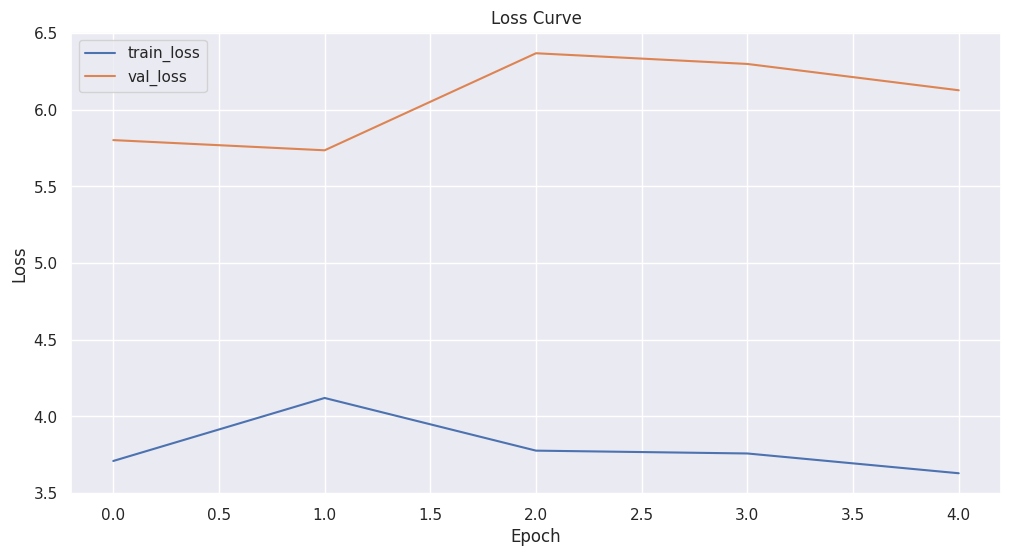

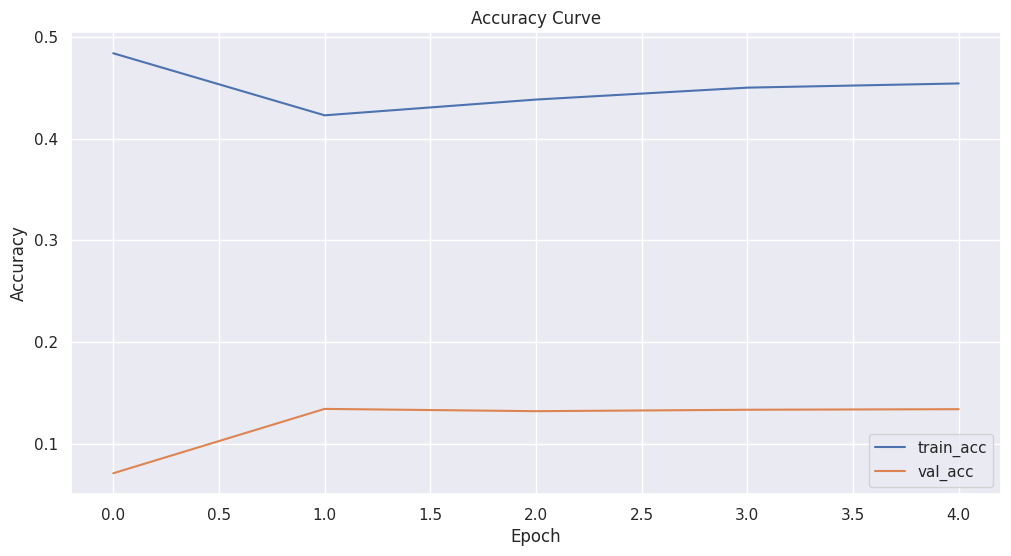

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Accuracy: 0.1185
Precision (macro): 0.0166
Recall (macro): 0.0931
F1-score (macro): 0.0273
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   45   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   26   7]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   43  29]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  236  19]
 [  0   0   0   0   0   0   0   0   0   0   0  

{'accuracy': np.float64(0.11850554582603619),
 'precision': 0.016566897737933912,
 'recall': 0.09305555555555556,
 'f1_score': 0.02727113146203592,
 'final_train_accuracy': 0.45421546697616577,
 'final_train_loss': 3.629812002182007}

In [49]:
AdamW()

In [ ]:
SDG()

In [40]:
random_for_class()

[PROGRESS] Fitting model 1 of 1
[INFO] Best model saved as 'best_randomforestclassifier_model.pkl'
[TEST] Model:  RandomForestClassifier
[TEST] Accuracy: 36.30 %
[TEST] F1-score : 25.48 %
[TEST] Precision : 27.64 %
[TEST] Recall : 29.14 %
[TEST] Confusion Matrix:
 [[2.820e+02 1.550e+02 0.000e+00 2.200e+00 4.000e-01 1.000e+00 0.000e+00
  6.000e+00 2.000e+00 2.000e-01 1.400e+00 2.000e-01 6.000e-01 8.200e+00
  0.000e+00 2.600e+00 3.800e+00 1.200e+01 1.000e+00 3.400e+00]
 [6.980e+01 2.000e+02 0.000e+00 2.000e-01 0.000e+00 0.000e+00 0.000e+00
  6.000e-01 2.000e-01 0.000e+00 1.200e+00 3.400e+00 0.000e+00 0.000e+00
  0.000e+00 1.900e+01 8.000e-01 6.000e-01 2.200e+00 1.000e+00]
 [6.180e+01 1.212e+02 0.000e+00 2.000e-01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 8.000e-01]
 [1.560e+01 1.400e+00 0.000e+00 3.500e+01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 6.000e-01 2.000e-01 

[{'model': 'RandomForestClassifier',
  'accuracy': np.float64(0.3629896083133493),
  'f1_score': np.float64(0.25480149918057743),
  'precision': np.float64(0.27638620029348915),
  'recall': np.float64(0.2913789998059503),
  'confusion_matrix': array([[2.820e+02, 1.550e+02, 0.000e+00, 2.200e+00, 4.000e-01, 1.000e+00,
          0.000e+00, 6.000e+00, 2.000e+00, 2.000e-01, 1.400e+00, 2.000e-01,
          6.000e-01, 8.200e+00, 0.000e+00, 2.600e+00, 3.800e+00, 1.200e+01,
          1.000e+00, 3.400e+00],
         [6.980e+01, 2.000e+02, 0.000e+00, 2.000e-01, 0.000e+00, 0.000e+00,
          0.000e+00, 6.000e-01, 2.000e-01, 0.000e+00, 1.200e+00, 3.400e+00,
          0.000e+00, 0.000e+00, 0.000e+00, 1.900e+01, 8.000e-01, 6.000e-01,
          2.200e+00, 1.000e+00],
         [6.180e+01, 1.212e+02, 0.000e+00, 2.000e-01, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,978,420 (22.81 MB)

 Trainable params: 5,978,420 (22.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 556s 6s/step - accuracy: 0.3769 - loss: 30.2395 - val_accuracy: 0.2030 - val_loss: 3.0764
Epoch 2/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 513s 5s/step - accuracy: 0.3040 - loss: 2.5636 - val_accuracy: 0.2341 - val_loss: 3.2540
Epoch 3/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 538s 6s/step - accuracy: 0.5678 - loss: 1.6751 - val_accuracy: 0.2890 - val_loss: 2.5512
Epoch 4/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 562s 6s/step - accuracy: 0.5742 - loss: 1.5208 - val_accuracy: 0.2921 - val_loss: 2.8439
Epoch 5/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 554s 6s/step - accuracy: 0.5981 - loss: 1.4782 - val_accuracy: 0.2974 - val_loss: 3.3467
Epoch 6/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 532s 6s/step - accuracy: 0.7084 - loss: 1.0372 - val_accuracy: 0.3005 - val_loss: 3.6752
Epoch 7/7
95/95 ━━━━━━━━━━━━━━━━━━━━ 574s 6s/step - accuracy: 0.6620 - loss: 1.3144 - val_accuracy: 0.3251 - val_loss: 3.2032


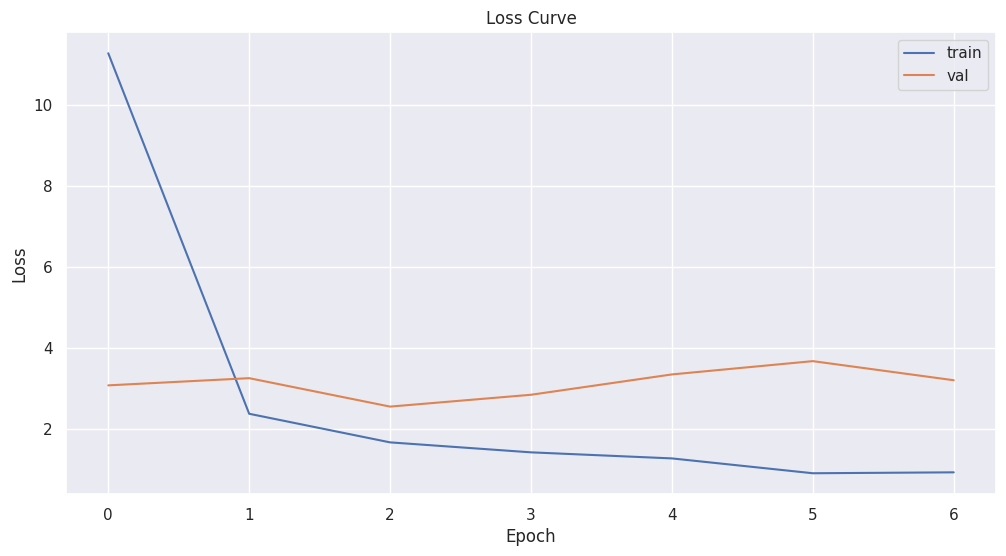

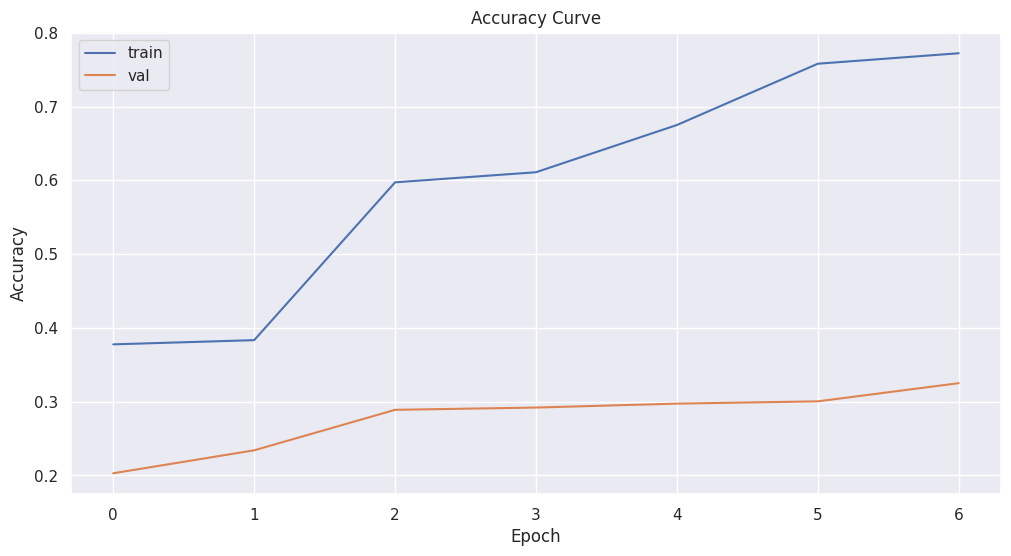

In [47]:
simple_cnn()

In [44]:
# Assuming the 'model' variable from the simple_cnn function
# is accessible in your current Colab environment.
# If not, you might need to find the variable name holding the trained model.

try:
    # Attempt to save the model with the correct extension
    model.save("saved_simple_cnn_model.keras")
    print("Model saved successfully with .keras extension.")
except NameError:
    print("Error: The 'model' variable was not found. Make sure the simple_cnn function was executed and the model variable is accessible.")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Error: The 'model' variable was not found. Make sure the simple_cnn function was executed and the model variable is accessible.


Average Accuracy     : 22.28%
Average F1-score     : 11.45%
Average Precision    : 13.31%
Average Recall       : 14.94%


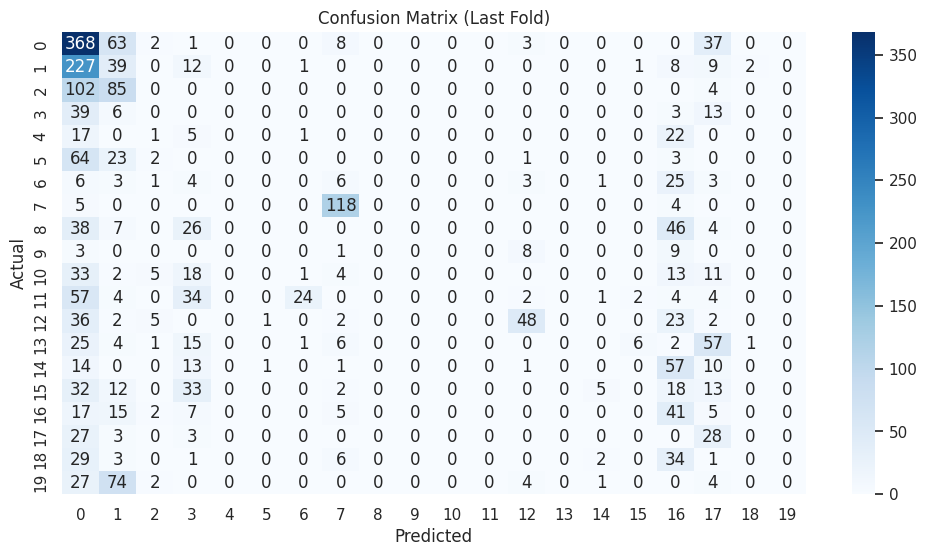

In [37]:
sgd_class()

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [50]:

from joblib import load
def make_predictions(model, X_test, y_true_grouped, print_eval=True):
    print("Making predictions...")
    try:
        if isinstance(model, tf.keras.Model):
            test_preds_proba = model.predict(X_test)
            test_preds_exploded = pd.DataFrame(np.argmax(test_preds_proba, axis=1), index=X_test.index)
        elif isinstance(model, (SGDClassifier, RandomForestClassifier, Pipeline)):
            test_preds_exploded = pd.DataFrame(model.predict(X_test), index=X_test.index)
        else:
            raise TypeError(f"Unsupported model type for predictions: {type(model)}")
        print("Predictions on exploded data complete.")

    except Exception as e:
        print(f"Error during model prediction: {e}")
        return None, None


    print("Grouping predictions by index...")
    try:
        grouped_test_preds = group_df_by_index(test_preds_exploded)
        grouped_test_preds.columns = ['predicted_category']
        print("Predictions grouped.")
    except Exception as e:
        print(f"Error grouping predictions: {e}")
        return None, None


    print("Aligning true labels...")
    try:
        y_true_aligned = y_true_grouped.reindex(grouped_test_preds.index)
        print("True labels aligned.")
    except Exception as e:
        print(f"Error aligning true labels: {e}")
        return None, grouped_test_preds


    results = None
    if print_eval:
        print("\nEvaluating model performance...")
        try:
            if len(y_true_aligned) != len(grouped_test_preds):
                 print("Warning: Lengths of true and predicted labels do not match after grouping/reindexing.")
                 print(f"True labels length: {len(y_true_aligned)}, Predicted labels length: {len(grouped_test_preds)}")

            cf_mat = confusion_matrix(y_true_aligned, grouped_test_preds['predicted_category'])
            f1 = f1_score(y_true_aligned, grouped_test_preds['predicted_category'], average='macro', zero_division=0)
            precision = precision_score(y_true_aligned, grouped_test_preds['predicted_category'], average='macro', zero_division=0)
            recall = recall_score(y_true_aligned, grouped_test_preds['predicted_category'], average='macro', zero_division=0)
            accuracy = accuracy_score(y_true_aligned, grouped_test_preds['predicted_category'])

            print("\n[Model TEST RESULTS]")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (macro): {precision:.4f}")
            print(f"Recall (macro): {recall:.4f}")
            print(f"F1-score (macro): {f1:.4f}")
            print("Confusion Matrix:")
            print(cf_mat)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cf_mat, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {type(model).__name__}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            results = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'confusion_matrix': cf_mat
            }

        except Exception as e:
            print(f"An error occurred during evaluation: {e}")
            results = None

    return results, grouped_test_preds

In [51]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

sgd_model_path = '/content/best_sgd_model.pkl'



loaded_sgd_model = None
if os.path.exists(sgd_model_path):
    try:
        loaded_sgd_model = load(sgd_model_path)
        print(f"SGDClassifier{sgd_model_path}")

    except Exception as e:
        print(f"Error loading SGDClassifier model from {sgd_model_path}: {e}")
else:
    print(f"Error: SGDClassifier model file not found at {sgd_model_path}.")


sgd_grouped_predictions = None
if loaded_sgd_model is not None:

    try:
        X_test_data = TEST[predictors]
    except NameError:
        print("Error: 'TEST' or 'predictors' not found. Ensure data loading/splitting cells were run.")
        X_test_data = None


    if X_test_data is not None:
        try:
            test_preds_exploded = pd.DataFrame(loaded_sgd_model.predict(X_test_data), index=X_test_data.index, columns=['predicted_category'])

            try:
                sgd_grouped_predictions = group_df_by_index(test_preds_exploded)
                sgd_grouped_predictions.columns = ['predicted_category']

                print(sgd_grouped_predictions.head())


                try:
                    y_true_grouped_data = GT_grouped_test['category']

                    y_true_aligned = y_true_grouped_data.reindex(sgd_grouped_predictions.index)


                    cf_mat = confusion_matrix(y_true_aligned, sgd_grouped_predictions['predicted_category'])
                    f1 = f1_score(y_true_aligned, sgd_grouped_predictions['predicted_category'], average='macro', zero_division=0)
                    precision = precision_score(y_true_aligned, sgd_grouped_predictions['predicted_category'], average='macro', zero_division=0)
                    recall = recall_score(y_true_aligned, sgd_grouped_predictions['predicted_category'], average='macro', zero_division=0)
                    accuracy = accuracy_score(y_true_aligned, sgd_grouped_predictions['predicted_category'])



                except NameError:
                     print("Error: 'GT_grouped_test' not found")
                except Exception as e:
                    print(f"An error occurred {e}")


            except NameError:
                 print("Error: 'group_df_by_index' function not found. Ensure the function definition cell was run.")
                 sgd_grouped_predictions = None
            except Exception as e:
                print(f"An error occurred during grouping: {e}")
                sgd_grouped_predictions = None


        except Exception as e:
            print(f"An error occurred during prediction: {e}")



else:
    print("SGDClassifier model was not loaded.")

SGDClassifier/content/best_sgd_model.pkl
           predicted_category
32  Acrocephalus arundinaceus
33  Acrocephalus arundinaceus
34   Acrocephalus melanopogon
35        Gallinula chloropus
36  Acrocephalus arundinaceus


Congratulations!!
